This is an instance of QAOA for solving the traveling salesman problem (TSP).


In [ ]:
!pip install qiskit ipywidgets # Installing qiskit for Google Colab
!pip install qiskit-optimization # Needed for an optimzer used (see comment for a specific import)
!pip install cplex # Needed for the CPLEX - it can solve specific types of optimization problems that can be represented as linear or quadratic functions

# This code is related to (not the same) the code made in a separate program, which was an internship I was a part of.
# Importing the mandatory, non-qiskit packages

import numpy as np
import math
import matplotlib.pyplot as plt
import operator

import sys
# Just to make sure there are no issues with the python version for the usage of sys.
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

# this is just to make sure there are no issues no matter which platform is being used.
try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")

# Importing packages related to qiskit
from qiskit import Aer, transpile
from qiskit.quantum_info import Pauli
from qiskit.utils import *
from qiskit.algorithms import NumPyMinimumEigensolver, VQE, QAOA
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import *

# For the quantum optimizer
from qiskit_optimization.algorithms import MinimumEigenOptimizer # Related to the second item installed
from qiskit_optimization import QuadraticProgram


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Setting up the needed nodes + depot and vehicles as the input parameters for TSP
n = 3 # Nodes + depot
v = 1 # vehicles

In [ ]:
# Create an initializer class that sets up what is needed to visualize potential solutions
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):
        n = self.n
        np.random.seed(1000)
        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10
        instance = np.zeros([n, n]) # This is relevant for the below classical optimizer code
        for ii in range(0, n):
            for jj in range(ii + 1, n): # This for loop is based a previous internship's code
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [ ]:
# Initialize the problem by randomly generating the instance (based on the initializer class)
initializer = Initializer(n) # Initializer object
xc,yc,instance = initializer.generate_instance()

In [ ]:
# Creating a class for the classical optimizer
class ClassicalOptimizer:

    def __init__(self, instance,n,v):

        self.instance = instance
        self.n = n  # number of nodes
        self.v = v  # number of vehicles


    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.v) / f(self.n-self.v)

    """This uses the classical IBM cplex optimizer. 
    This function and the one right below it was directly based on internship-related code."""
    
    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        v = self.v

        my_obj = list(instance.reshape(1, n**2)[0])+[0. for x in range(0,n-1)]
        my_ub = [1 for x in range(0,n**2+n-1)]
        my_lb = [0 for x in range(0,n**2)] + [0.1 for x in range(0,n-1)]
        my_ctype = "".join(['I' for x in range(0,n**2)]) + "".join(['C' for x in range(0,n-1)])

        my_rhs = 2*([v] + [1 for x in range(0,n-1)]) + [1-0.1 for x in range(0,(n-1)**2-(n-1))] + [0 for x in range(0,n)]
        my_sense = "".join(['E' for x in range(0,2*n)]) + "".join(['L' for x in range(0,(n-1)**2-(n-1))])+"".join(['E' for x in range(0,n)])

        my_prob = cplex.Cplex()
        self.populatebyrow(my_prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs)
        my_prob.solve()

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x,cost


    def populatebyrow(self,prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs):
        n = self.n
        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj = my_obj, lb = my_lb, ub = my_ub, types = my_ctype)
        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)
        rows = []
        for ii in range(0,n):
            col = [x for x in range(0+n*ii,n+n*ii)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])

        for ii in range(0,n):
            col = [x for x in range(0+ii,n**2,n)]
            coef = [1 for x in range(0,n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints below (from internship code)
        for ii in range(0, n):
          for jj in range(0,n):
            if (ii != jj)and(ii*jj>0):
              col = [ii+(jj*n), n**2+ii-1, n**2+jj-1]
              coef = [1, 1, -1]
              rows.append([col, coef])

        for ii in range(0,n):
          col = [(ii)*(n+1)]
          coef = [1]
          rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [ ]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance,n,v)

# Print number of potential solutions
print('Number of potential solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

Number of potential solutions = 3.0


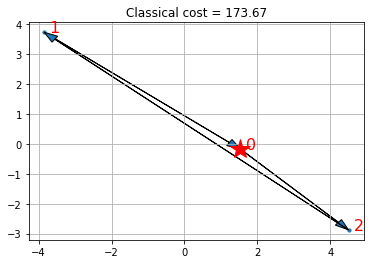

In [ ]:
# Visualize Solution Here
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=10)
    for i in range(len(xc)):
      plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)
    plt.grid()
    for ii in range(0, n ** 2): # This loop is from the internship code
      if x[ii] > 0:
        ix = ii // n
        iy = ii % n
        plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()

if x is not None: # In case only a good classical solution has been visualized
    visualize_solution(xc, yc, x, classical_cost, n, v, 'Classical')

In [ ]:
# This is the quantum optimizer class being used for QAOA
class quantumOptimizer:
  def __init__(self, instance, n, v):
    self.instance = instance
    self.n = n
    self.v = v

  def binary_representation(self,x_sol=0): # This function is identical to the one used by the internship and I have been given permission to use this code.
    instance = self.instance
    n = self.n
    v = self.v
    A = np.max(instance) * 100  # This is a parameter for the cost function

    # Determine the weights w needed
    instance_vec = instance.reshape(n ** 2)
    w_list = [instance_vec[x] for x in range(n ** 2) if instance_vec[x] > 0]
    w = np.zeros(n * (n - 1))
    for ii in range(len(w_list)):
      w[ii] = w_list[ii]

    # Some other needed variables
    Id_n = np.eye(n)
    Im_n_1 = np.ones([n - 1, n - 1])
    Iv_n_1 = np.ones(n)
    Iv_n_1[0] = 0
    Iv_n = np.ones(n-1)
    neg_Iv_n_1 = np.ones(n) - Iv_n_1
    v = np.zeros([n, n*(n-1)])

    for ii in range(n):
      count = ii-1
      for jj in range(n*(n-1)):
        if jj//(n-1) == ii:
          count = ii
        if jj//(n-1) != ii and jj%(n-1) == count:
          v[ii][jj] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A*(np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1,Iv_n) + vn.T) - \
                2 * A * v * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n-1) + 2 * A * (v ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost # Final Note: The above function was used from the internship-based code
  
 
  # This sets up all the variables from the previous function for the final quantum algorithm being run.
  def construct_problem(self, Q, g, c):
    qp = QuadraticProgram()
    for i in range(n * (n - 1)):
      qp.binary_var(str(i))
      qp.objective.quadratic = Q
      qp.objective.linear = g
      qp.objective.constant = c
    return qp

  def solve_problem(self, qp): # This function solves the function and allows one the get the optimal solution.
    algorithm_globals.random_seed = 10000 # Random number
    # This "quantum instance" code is used to run any qiskit-aqua based algorithm.
    quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
    qaoa = QAOA(optimizer = ADAM(), quantum_instance = quantum_instance, initial_point = [0,0])
    # ADAM() is a gradient-based optimizer
    # Random initial point
    optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa) # This converts the problem into a quantum unconstrained binary optimization (QUBO) problem.
    # Used to approxiate the ground state/lowest eneergy of the resulting hamiltonian
    result = optimizer.solve(qp)
    # used for computing cost of the obtained result (these two lines of code are from the internship code)
    _,_,_,level = self.binary_representation(x_sol=result.x) 
    return result.x, level


In [ ]:
# Solve the problem in a classical fashion via CPLEX, hence not putting initial values for x and z.
x = None
z = None
x,classical_cost = classical_optimizer.cplex_solution()
# Put the solution in the z variable
z = [x[ii] for ii in range(n**2) if ii//n != ii%n] # Had to research to find this line of code
# Print the solution
print(z)


[0.0, 1.0, 1.0, 0.0, 0.0, 1.0]


In [ ]:
# Initializing the quantum optimizer based on the related class and the original inputs (nodes and vehicles).
quantum_optimizer =  quantumOptimizer(instance, n, v) 

In [ ]:
# Outputting the binary cost of what was previously run
if z is not None:
  Q, g, c, binary_cost = quantum_optimizer.binary_representation(x_sol = z)
  print("Binary cost:", binary_cost, "classical cost:", classical_cost)
  if np.abs(binary_cost - classical_cost)  < 0.01:
    print('Binary formulation is correct')
  else: 
    print('Error in the binary formulation')
else: # In case the binary cost cannot be verified
  print('Could not verify the correctness, due to CPLEX solution being unavailable.')
  Q, g, c, binary_cost = quantum_optimizer.binary_representation()
  print("Binary cost:", binary_cost)

Binary cost: 0 classical cost: 173.67159502135212
Error in the binary formulation


In [ ]:
qp = quantum_optimizer.construct_problem(Q, g, c)
print(qp)
# Printing the equations, variables, and constraints used

QiskitOptimizationError: ignored

In [ ]:
quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)
print(quantum_solution, quantum_cost)
# Printing the quantum solution and the quantum cost
# The quantum solution is based on the variables and constraints used (see above printout for more information)

In [ ]:
 # Put the solution in a way that is compatible with the classical variables
 # This function was used from the internship, after some explanation from the mentor.
x_quantum = np.zeros(n**2)
b = 0
for a in range(n * n):
  if a // n != a % n: # if the larger float less than or equal to the division of a/n does not equal the remainder of a divided by n...
    x_quantum[a] = quantum_solution[b] # quantum_solution was created from the solve_problem method of the quantum_optimizer class
    b +=  1

In [ ]:
# visualize the quantum solution
visualize_solution(xc, yc, x_quantum, quantum_cost, n, v, 'Quantum')

In [ ]:
# and visualize the classical solution for comparison
if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, v, 'Classical')

In [ ]:
 print(xc,yc) # printing out two arrays, one housing all x-coordinates of the quantum solution graph and one housing
 # all of the respective y-coordinates